In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/data.csv'


In [ ]:
!pip install catboost
!pip install shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

from catboost import CatBoostRegressor, Pool, cv
# from catboost import MetricVisualizer

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from scipy.stats import boxcox
from os import listdir

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 9.5 MB/s eta 0:00:00


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/data.csv", encoding="ISO-8859-1", dtype={'CustomerID': str})
data.shape

(541909, 8)

In [ ]:
data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [ ]:
missing_percentage = data.isnull().sum() / data.shape[0] * 100
missing_percentage

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [ ]:
data[data.Description.isnull()].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom


In [ ]:
data[data.Description.isnull()].CustomerID.isnull().value_counts()


True    1454
Name: CustomerID, dtype: int64

In [ ]:
data[data.Description.isnull()].UnitPrice.value_counts()


0.0    1454
Name: UnitPrice, dtype: int64

In [ ]:
data[data.CustomerID.isnull()].head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom


In [ ]:
data.loc[data.CustomerID.isnull(), ["UnitPrice", "Quantity"]].describe()


,UnitPrice,Quantity
count,135080.000000,135080.000000
mean,8.076577,1.995573
std,151.900816,66.696153
min,-11062.060000,-9600.000000
25%,1.630000,1.000000
50%,3.290000,1.000000
75%,5.450000,3.000000
max,17836.460000,5568.000000


In [ ]:
data.loc[data.Description.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.Description.isnull()==False,"Description"
].apply(lambda l: l.lower())

data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("nan" in l, True, False)
).value_counts()

False    539724
True        731
Name: lowercase_descriptions, dtype: int64

In [ ]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    540455
Name: lowercase_descriptions, dtype: int64

In [ ]:
data.lowercase_descriptions.dropna().apply(
    lambda l: np.where("" == l, True, False)
).value_counts()

False    540455
Name: lowercase_descriptions, dtype: int64

In [ ]:
data.loc[data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"] = data.loc[
    data.lowercase_descriptions.isnull()==False, "lowercase_descriptions"
].apply(lambda l: np.where("nan" in l, None, l))

In [ ]:
data = data.loc[(data.CustomerID.isnull()==False) & (data.lowercase_descriptions.isnull()==False)].copy()

In [ ]:
data.isnull().sum().sum()


0

In [ ]:
data["InvoiceDate"] = pd.to_datetime(data.InvoiceDate, cache=True)

data.InvoiceDate.max() - data.InvoiceDate.min()

Timedelta('373 days 04:24:00')

In [ ]:
print("Datafile starts with timepoint {}".format(data.InvoiceDate.min()))
print("Datafile ends with timepoint {}".format(data.InvoiceDate.max()))

Datafile starts with timepoint 2010-12-01 08:26:00
Datafile ends with timepoint 2011-12-09 12:50:00


In [ ]:
data.InvoiceNo.nunique()


22186

In [ ]:
data["IsCancelled"]=np.where(data.InvoiceNo.apply(lambda l: l[0]=="C"), True, False)
data.IsCancelled.value_counts() / data.shape[0] * 100

False    97.81007
True      2.18993
Name: IsCancelled, dtype: float64

In [ ]:
data.loc[data.IsCancelled==True].describe()

,Quantity,UnitPrice
count,8896.000000,8896.000000
mean,-30.882981,18.862815
std,1170.746458,444.590459
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,4.950000
max,-1.000000,38970.000000


In [ ]:
data = data.loc[data.IsCancelled==False].copy()
data = data.drop("IsCancelled", axis=1)

In [ ]:
data.StockCode.nunique()


3663

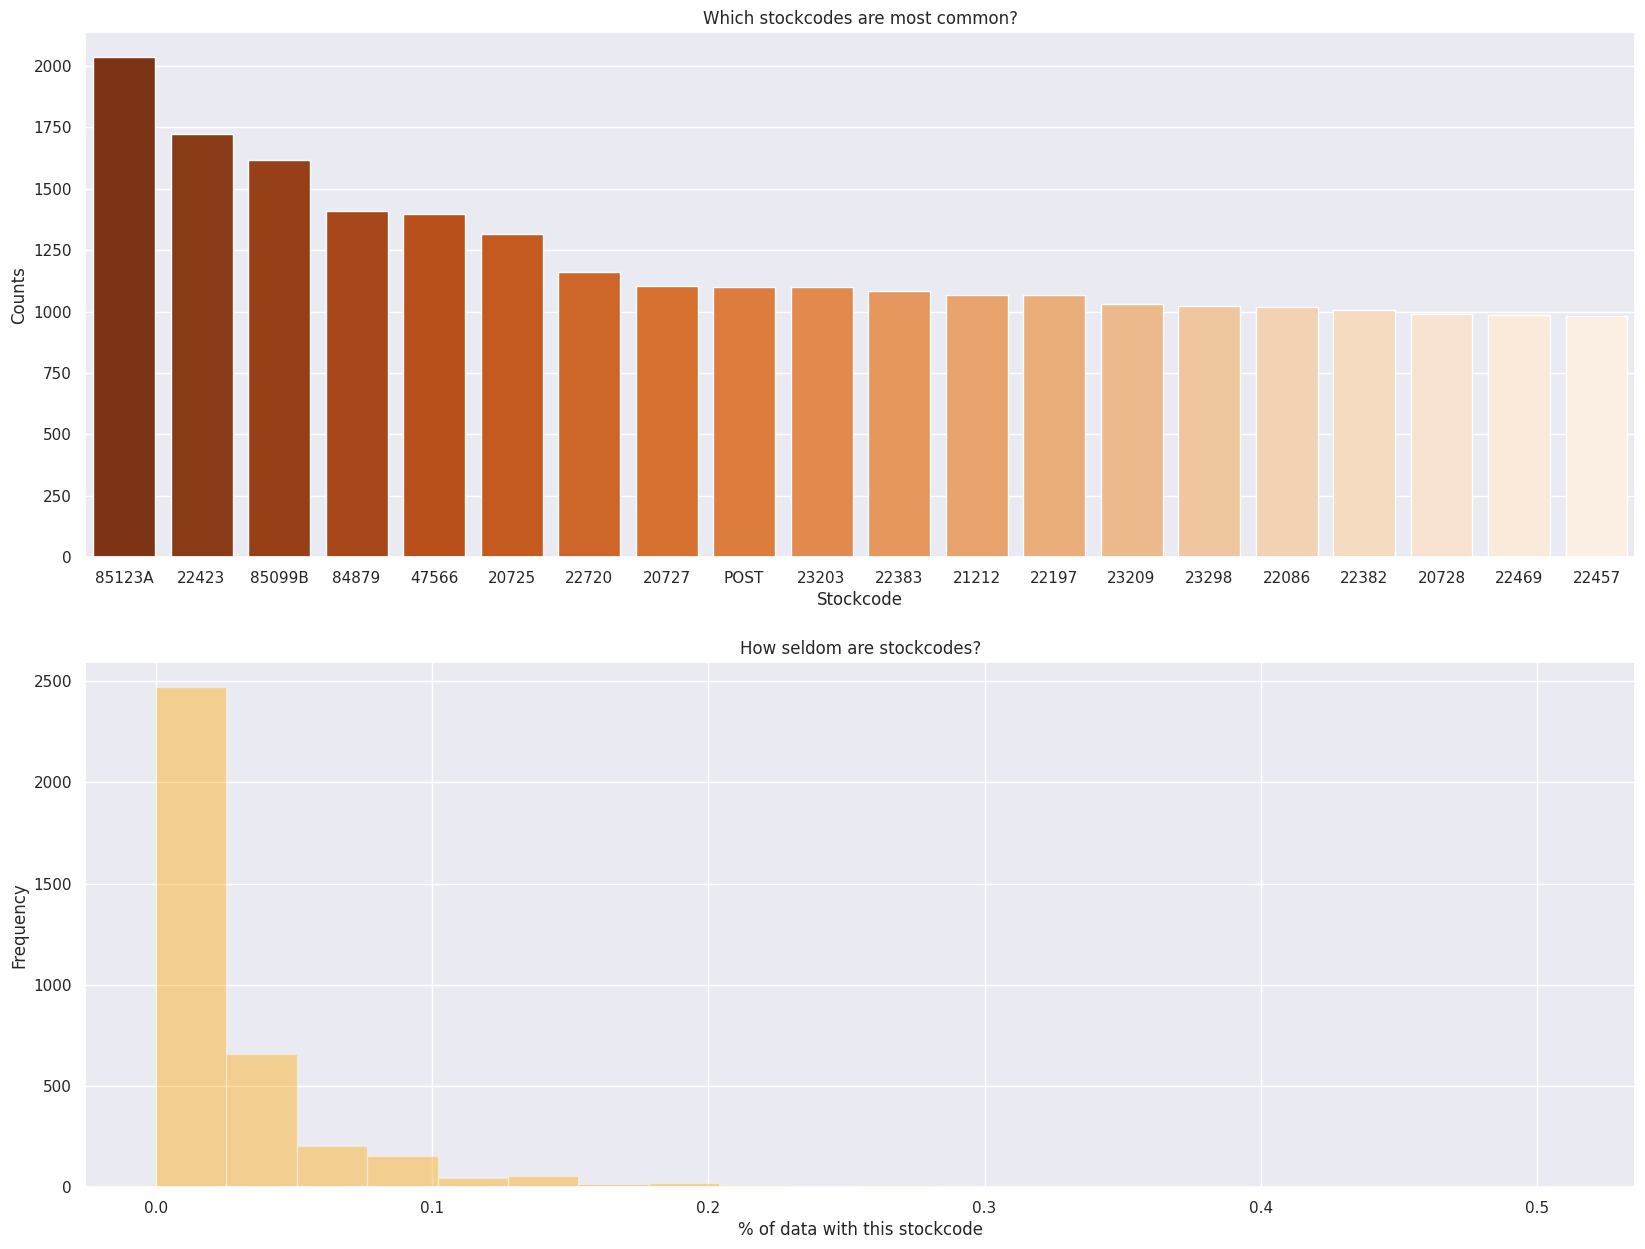

In [ ]:



# Calculate stock code counts
stockcode_counts = data['StockCode'].value_counts().sort_values(ascending=False)

# Create subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 15))

# Bar plot for the most common stock codes
sns.barplot(x=stockcode_counts.iloc[0:20].index,
            y=stockcode_counts.iloc[0:20].values,
            ax=ax[0], palette="Oranges_r")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?")

# Histogram for the distribution of stock codes
sns.distplot(np.round(stockcode_counts/data.shape[0]*100, 2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency")

# Show the plots
plt.show()


In [ ]:
def count_numeric_chars(l):
    return sum(1 for c in l if c.isdigit())

data["StockCodeLength"] = data.StockCode.apply(lambda l: len(l))
data["nNumericStockCode"] = data.StockCode.apply(lambda l: count_numeric_chars(l))

In [ ]:
print(data["StockCodeLength"].unique())
print(data["nNumericStockCode"].unique())

[ 6  5  4  7  2  1 12  3]
[5 0 1]


In [ ]:
data.loc[data.nNumericStockCode < 5].lowercase_descriptions.value_counts()


postage                       1099
manual                         290
carriage                       133
dotcom postage                  16
bank charges                    12
pads to match all cushions       4
Name: lowercase_descriptions, dtype: int64

In [ ]:
data = data.loc[(data.nNumericStockCode == 5) & (data.StockCodeLength==5)].copy()
data.StockCode.nunique()

2783

In [ ]:
data = data.drop(["nNumericStockCode", "StockCodeLength"], axis=1)


In [ ]:
data.Description.nunique()


2983

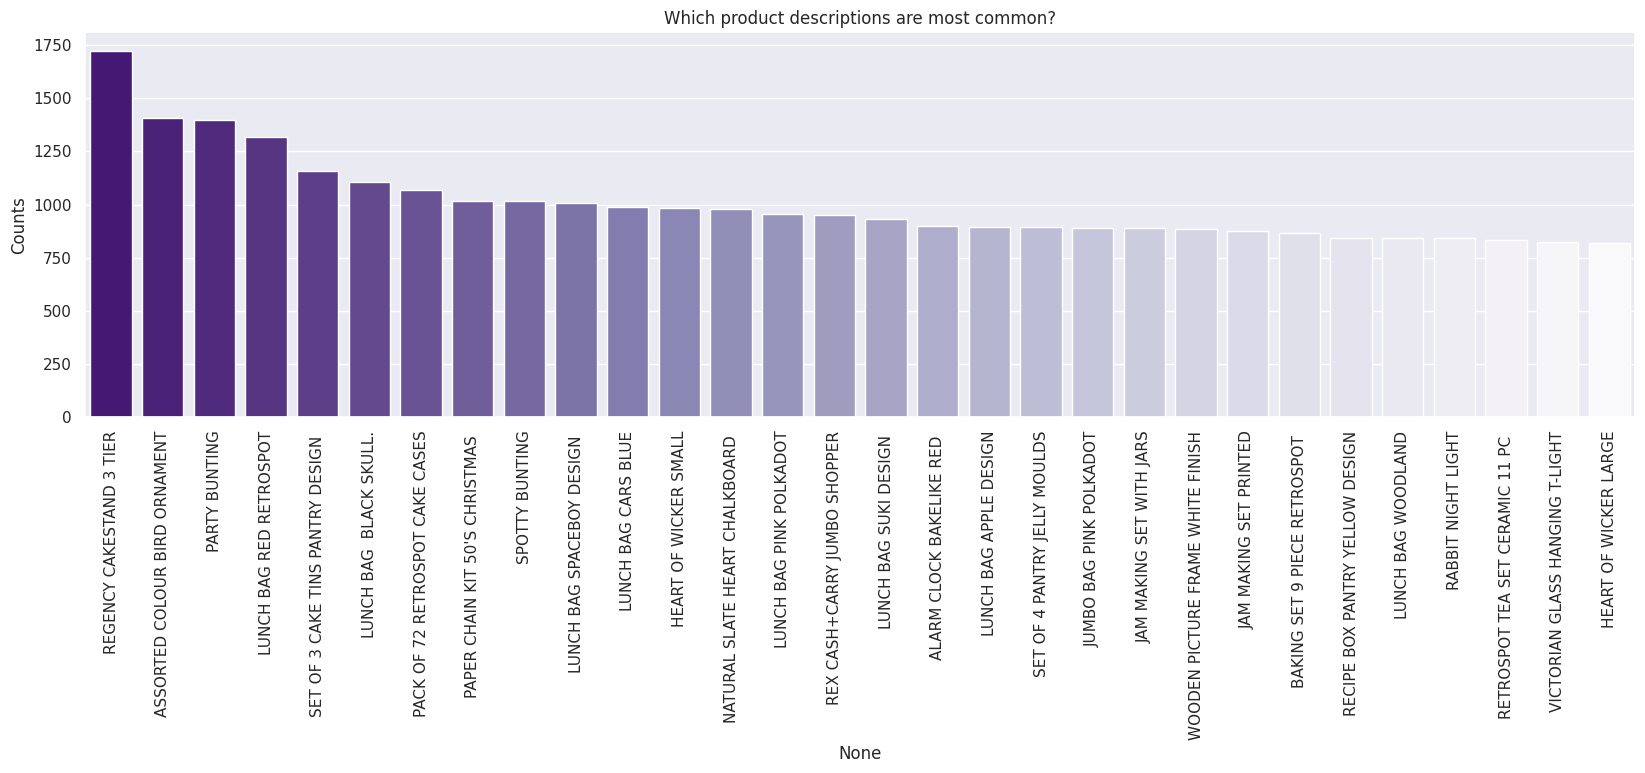

In [ ]:
# Assuming you already have your 'data' DataFrame defined

# Get the counts of each product description and select the top 30
description_counts = data['Description'].value_counts().sort_values(ascending=False).iloc[0:30]

# Create a bar plot for the most common product descriptions
plt.figure(figsize=(20, 5))
sns.barplot(x=description_counts.index, y=description_counts.values, palette="Purples_r")

# Set labels and title
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

# Show the plot
plt.show()


In [ ]:
def count_lower_chars(l):
    return sum(1 for c in l if c.islower())

In [ ]:
data["DescriptionLength"] = data.Description.apply(lambda l: len(l))
data["LowCharsInDescription"] = data.Description.apply(lambda l: count_lower_chars(l))

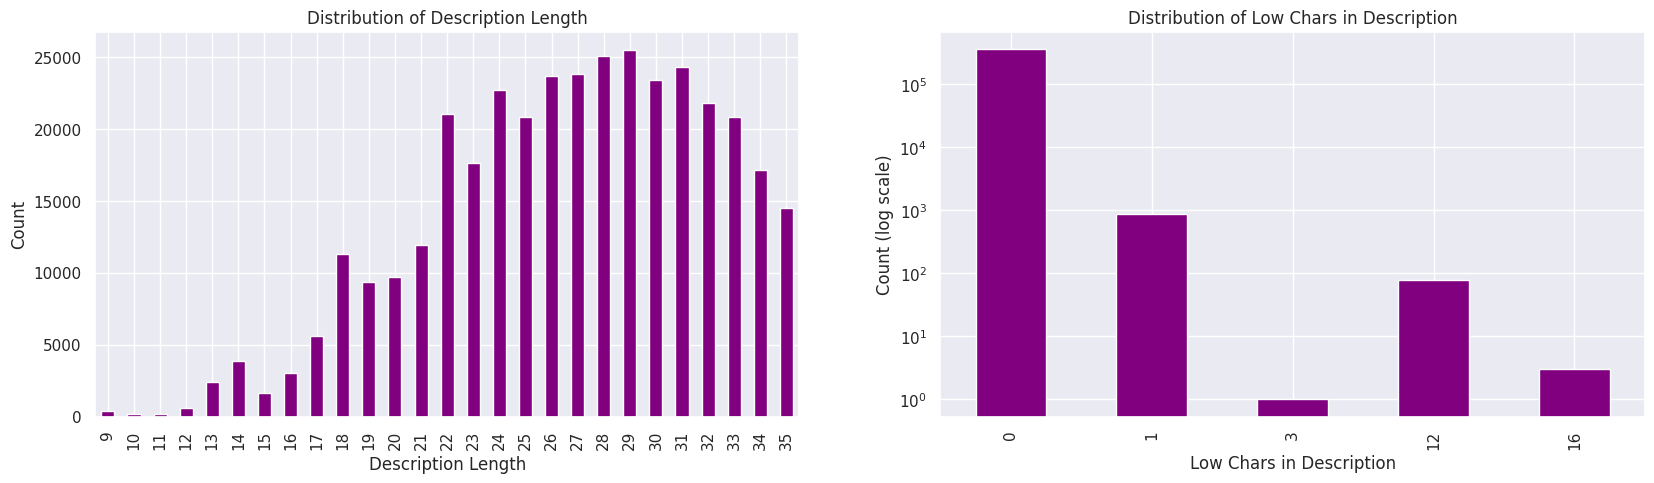

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have your 'data' DataFrame defined

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot the distribution of "DescriptionLength"
data["DescriptionLength"].value_counts().sort_index().plot(kind='bar', ax=ax[0], color="Purple")
ax[0].set_xlabel("Description Length")
ax[0].set_ylabel("Count")
ax[0].set_title("Distribution of Description Length")

# Plot the distribution of "LowCharsInDescription" with log scale on y-axis
data["LowCharsInDescription"].value_counts().sort_index().plot(kind='bar', ax=ax[1], color="Purple", logy=True)
ax[1].set_xlabel("Low Chars in Description")
ax[1].set_ylabel("Count (log scale)")
ax[1].set_title("Distribution of Low Chars in Description")

# Show the plots
plt.show()


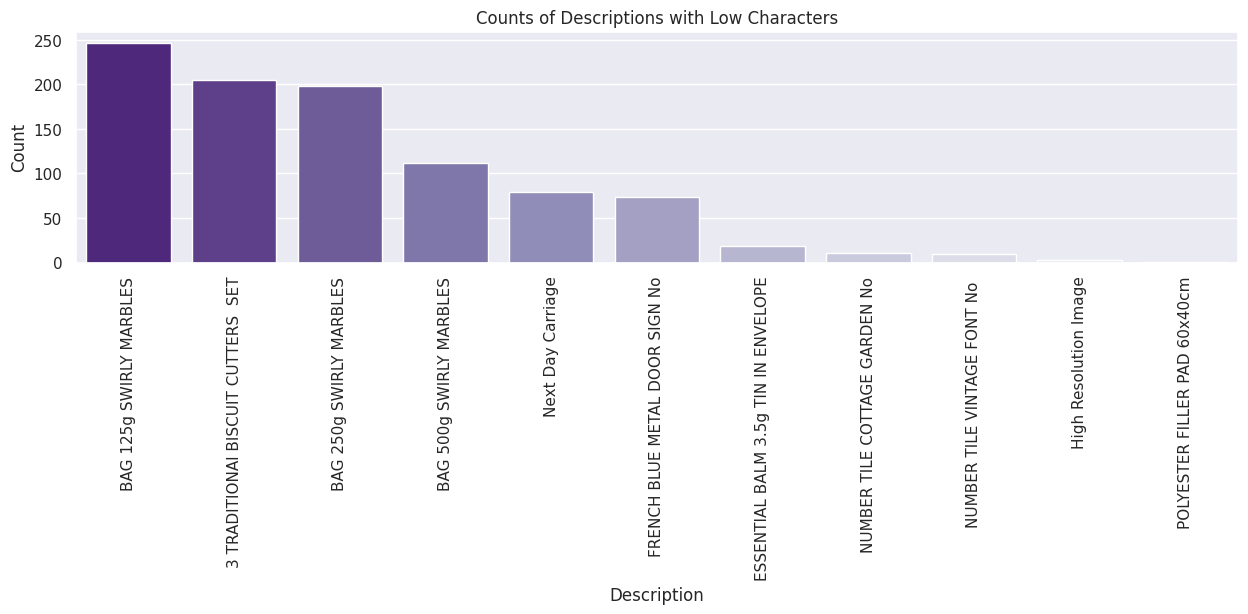

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have your 'data' DataFrame defined

# Filter data for descriptions with low characters
lowchar_counts = data[data['LowCharsInDescription'] > 0]['Description'].value_counts()

# Create a bar plot for counts of descriptions with low characters
plt.figure(figsize=(15, 3))
sns.barplot(x=lowchar_counts.index, y=lowchar_counts.values, palette="Purples_r")
plt.xlabel("Description")
plt.ylabel("Count")
plt.title("Counts of Descriptions with Low Characters")
plt.xticks(rotation=90)
plt.show()


In [ ]:
import pandas as pd



# Function to count uppercase characters
count_upper_chars = lambda s: sum(1 for c in s if c.isupper())

# Apply the function to create a new column
data["UpCharsInDescription"] = data["Description"].apply(count_upper_chars)

# Display summary statistics for the new column
print(data["UpCharsInDescription"].describe())


count    362522.000000
mean         22.572291
std           4.354845
min           3.000000
25%          20.000000
50%          23.000000
75%          26.000000
max          32.000000
Name: UpCharsInDescription, dtype: float64


In [ ]:
data.loc[data.UpCharsInDescription <=5].Description.value_counts()


Next Day Carriage        79
High Resolution Image     3
Name: Description, dtype: int64

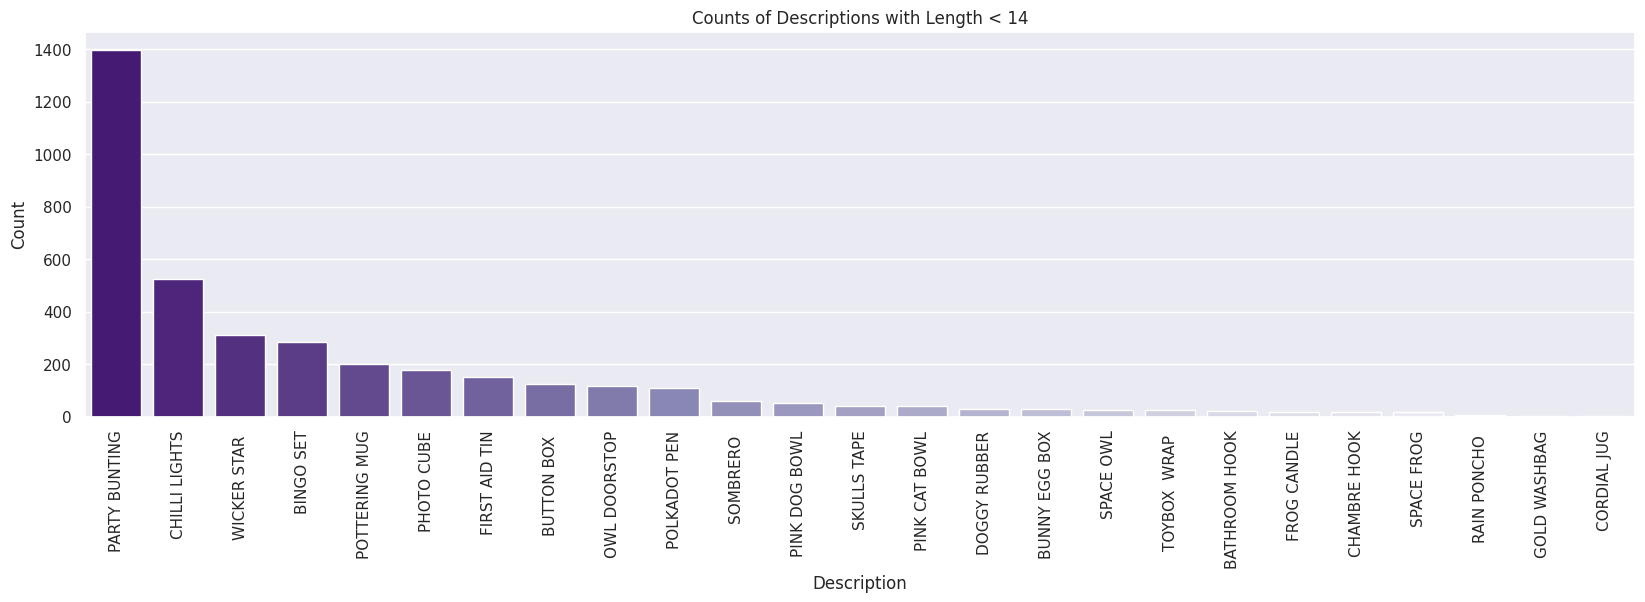

In [ ]:


# Filter rows where 'DescriptionLength' is less than 14 and get value counts
filtered_counts = data.loc[data['DescriptionLength'] < 14]['Description'].value_counts()

# Create a bar plot for counts of descriptions with 'DescriptionLength' less than 14
plt.figure(figsize=(20, 5))
sns.barplot(x=filtered_counts.index, y=filtered_counts.values, palette="Purples_r")
plt.xlabel("Description")
plt.ylabel("Count")
plt.title("Counts of Descriptions with Length < 14")
plt.xticks(rotation=90)
plt.show()


In [ ]:
data.CustomerID.nunique()


4315

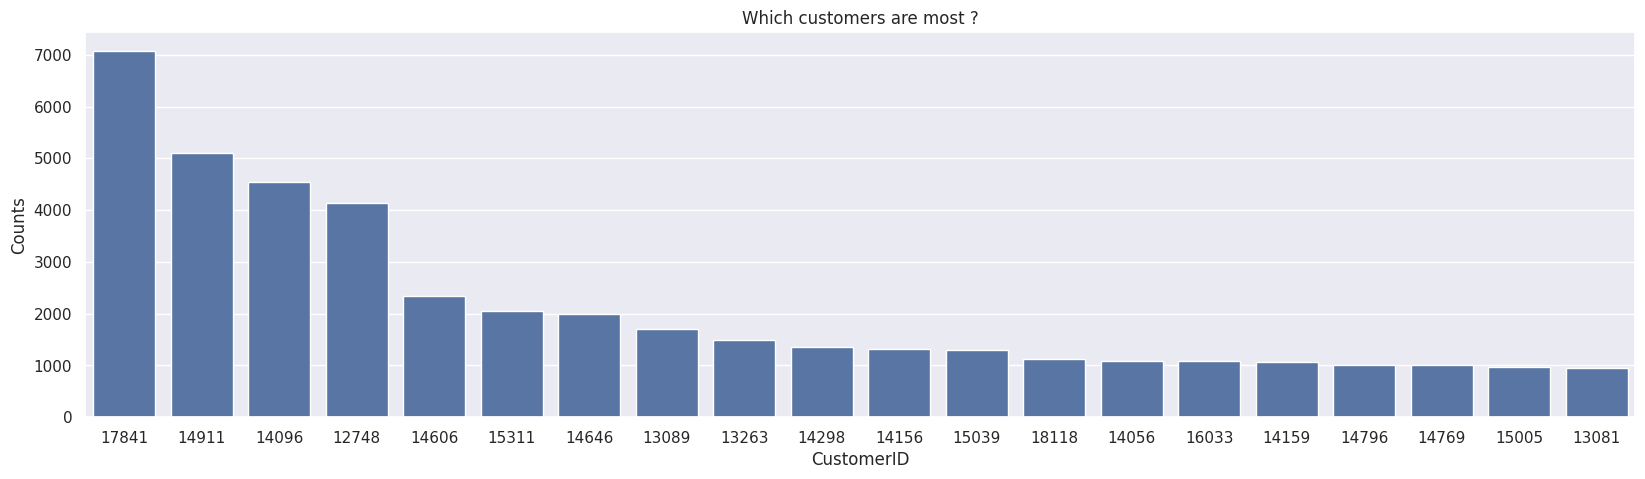

In [ ]:
customer_counts = data.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20, 5))
sns.barplot(x=customer_counts.index, y=customer_counts.values)
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most ?")
plt.show()


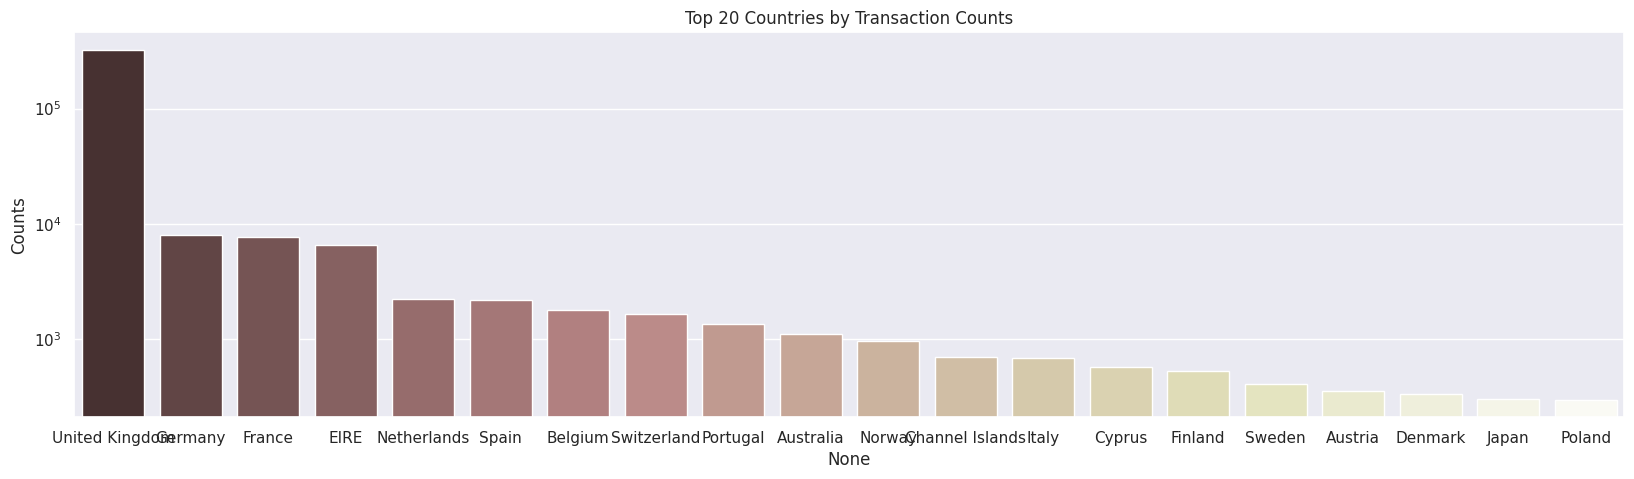

In [ ]:

# Get the top 20 countries based on transaction counts
country_counts = data['Country'].value_counts().nlargest(20)

# Create a bar plot
plt.figure(figsize=(20, 5))
sns.barplot(x=country_counts.index, y=country_counts.values, palette="pink")
plt.ylabel("Counts")
plt.title("Top 20 Countries by Transaction Counts")
plt.yscale("log")  # Apply log scale on the y-axis
plt.show()


In [ ]:
data.UnitPrice.describe()


count    362522.000000
mean          2.888083
std           4.365273
min           0.000000
25%           1.250000
50%           1.790000
75%           3.750000
max         649.500000
Name: UnitPrice, dtype: float64

ALL THESE BELOW ARE GIFTS
SO LETS REMOVE THEM

In [ ]:
data.loc[data.UnitPrice == 0].sort_values(by="Quantity", ascending=False).head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,lowercase_descriptions,DescriptionLength,LowCharsInDescription,UpCharsInDescription
502122,578841,84826,ASSTD DESIGN 3D PAPER STICKERS,12540,2011-11-25 15:57:00,0.0,13256,United Kingdom,asstd design 3d paper stickers,30,0,25
298054,562973,23157,SET OF 6 NATIVITY MAGNETS,240,2011-08-11 11:42:00,0.0,14911,EIRE,set of 6 nativity magnets,26,0,20
436428,574138,23234,BISCUIT TIN VINTAGE CHRISTMAS,216,2011-11-03 11:26:00,0.0,12415,Australia,biscuit tin vintage christmas,29,0,26
314746,564651,23268,SET OF 2 CERAMIC CHRISTMAS REINDEER,192,2011-08-26 14:19:00,0.0,14646,Netherlands,set of 2 ceramic christmas reindeer,35,0,29
314748,564651,21786,POLKADOT RAIN HAT,144,2011-08-26 14:19:00,0.0,14646,Netherlands,polkadot rain hat,18,0,15


In [ ]:
data = data.loc[data.UnitPrice > 0].copy()


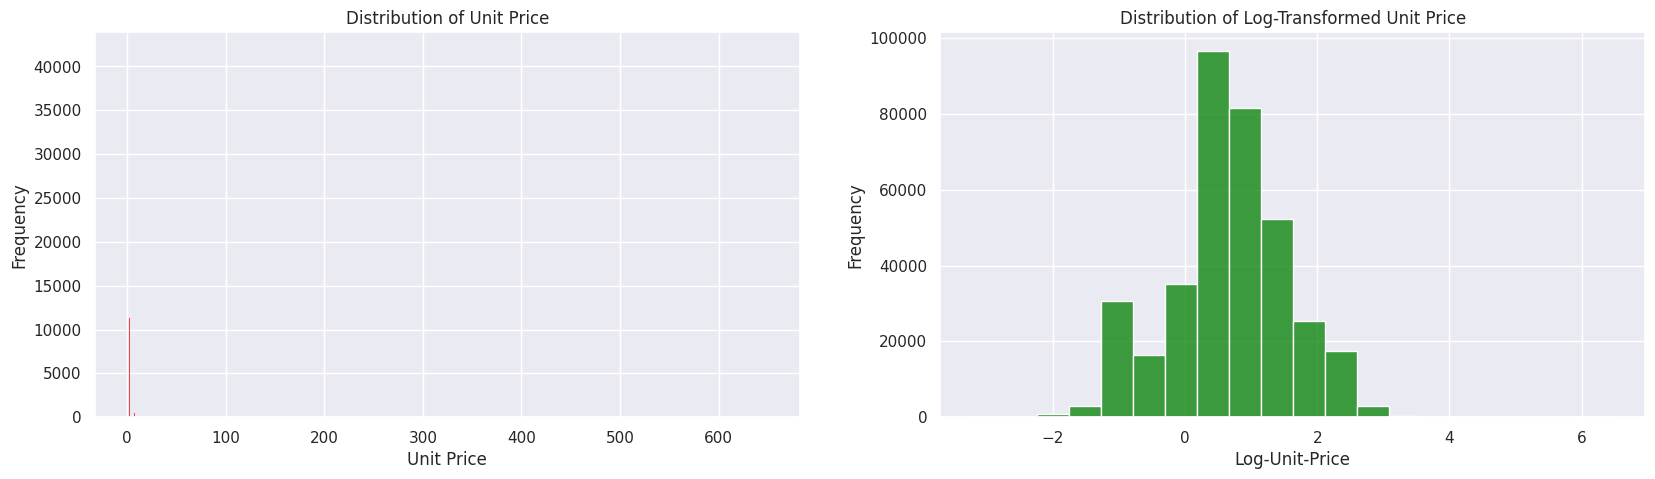

In [ ]:


# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot the distribution of 'UnitPrice'
sns.histplot(data['UnitPrice'], ax=ax[0], kde=False, color="red")
ax[0].set_xlabel("Unit Price")
ax[0].set_ylabel("Frequency")
ax[0].set_title("Distribution of Unit Price")

# Plot the distribution of log-transformed 'UnitPrice'
sns.histplot(np.log(data['UnitPrice']), ax=ax[1], bins=20, color="green", kde=False)
ax[1].set_xlabel("Log-Unit-Price")
ax[1].set_ylabel("Frequency")
ax[1].set_title("Distribution of Log-Transformed Unit Price")

# Show the plots
plt.show()


In [ ]:
np.exp(-2)


0.13533528323661267

In [ ]:
np.exp(3)


20.085536923187668

In [ ]:
np.quantile(data.UnitPrice, 0.95)


8.5

In [ ]:
data = data.loc[(data.UnitPrice > 0.1) & (data.UnitPrice < 20)].copy()


In [ ]:
data.Quantity.describe()


count    361688.000000
mean         13.021455
std         187.545850
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

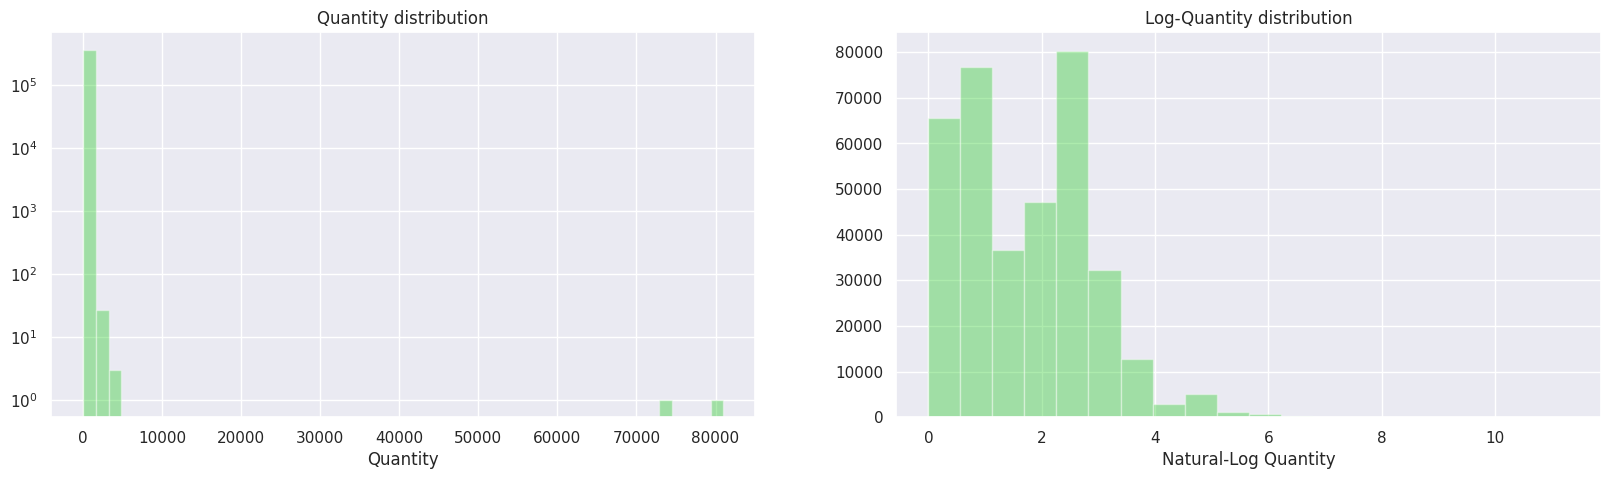

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(data.Quantity, ax=ax[0], kde=False, color="limegreen");
sns.distplot(np.log(data.Quantity), ax=ax[1], bins=20, kde=False, color="limegreen");
ax[0].set_title("Quantity distribution")
ax[0].set_yscale("log")
ax[1].set_title("Log-Quantity distribution")
ax[1].set_xlabel("Natural-Log Quantity");

In [ ]:
np.exp(4)


54.598150033144236

In [ ]:
np.quantile(data.Quantity, 0.95)


36.0

In [ ]:
data = data.loc[data.Quantity < 55].copy()


In [ ]:
import pandas as pd

# Calculate Revenue
data["Revenue"] = data["Quantity"] * data["UnitPrice"]

# Extract date-related features
data["Year"] = data["InvoiceDate"].dt.year
data["Quarter"] = data["InvoiceDate"].dt.quarter
data["Month"] = data["InvoiceDate"].dt.month

# Extract ISO week information
week_info = data["InvoiceDate"].dt.isocalendar()
data["Week"] = week_info["week"]

data["Weekday"] = data["InvoiceDate"].dt.weekday
data["Day"] = data["InvoiceDate"].dt.day
data["Dayofyear"] = data["InvoiceDate"].dt.dayofyear

# Create a new 'Date' column
data["Date"] = pd.to_datetime(data[["Year", "Month", "Day"]])


In [ ]:
grouped_features = ["Date", "Year", "Quarter","Month", "Week", "Weekday", "Dayofyear", "Day","StockCode"]

In [ ]:
daily_data = pd.DataFrame(data.groupby(grouped_features).Quantity.sum(),
                          columns=["Quantity"])
daily_data["Revenue"] = data.groupby(grouped_features).Revenue.sum()
daily_data = daily_data.reset_index()
daily_data.head(5)

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [ ]:
low_quantity = daily_data.Quantity.quantile(0.01)
high_quantity = daily_data.Quantity.quantile(0.99)
print((low_quantity, high_quantity))

(1.0, 88.0)


In [ ]:
low_revenue = daily_data.Revenue.quantile(0.01)
high_revenue = daily_data.Revenue.quantile(0.99)
print((low_revenue, high_revenue))

(0.78, 204.0)


In [ ]:
samples = daily_data.shape[0]


In [ ]:
daily_data = daily_data.loc[
    (daily_data.Quantity >= low_quantity) & (daily_data.Quantity <= high_quantity)]
daily_data = daily_data.loc[
    (daily_data.Revenue >= low_revenue) & (daily_data.Revenue <= high_revenue)]

In [ ]:
samples - daily_data.shape[0]


5258

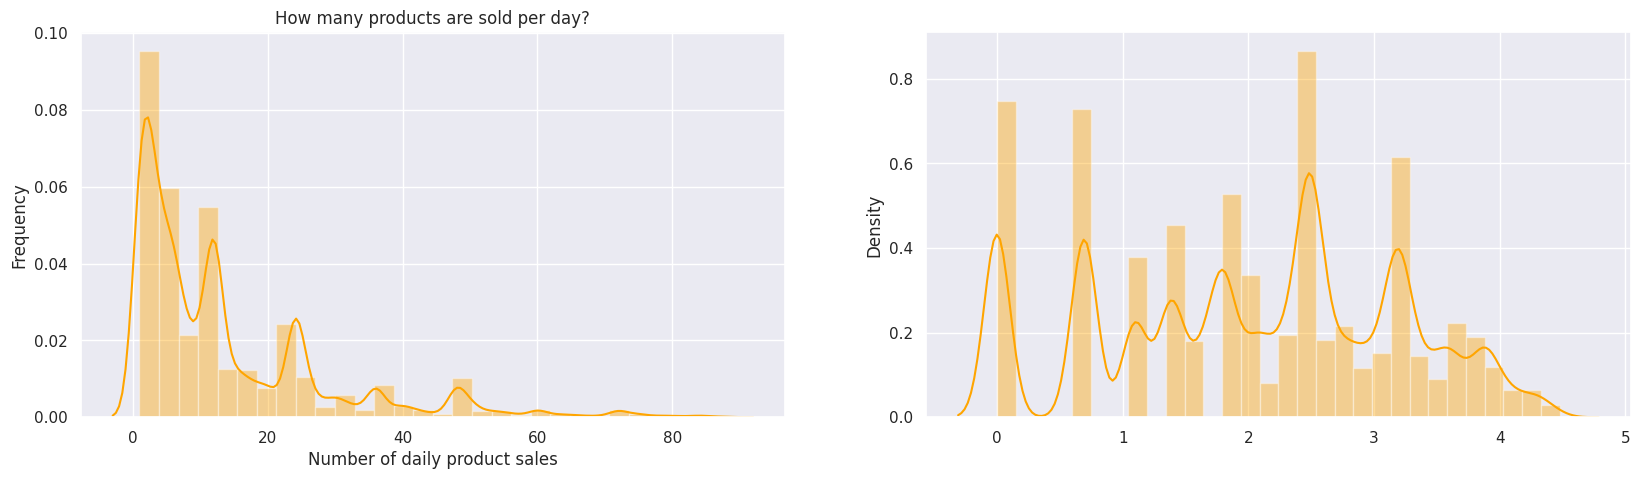

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.distplot(daily_data.Quantity.values, kde=True, ax=ax[0], color="Orange", bins=30);
sns.distplot(np.log(daily_data.Quantity.values), kde=True, ax=ax[1], color="Orange", bins=30);
ax[0].set_xlabel("Number of daily product sales");
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many products are sold per day?");

In [ ]:
class CatHyperparameter:

    def __init__(self,
                 loss="RMSE",
                 metric="RMSE",
                 iterations=1000,
                 max_depth=4,
                 l2_leaf_reg=3,
                 # learning_rate=0.5,
                 seed=0):
        self.loss = [loss]  # Corrected attribute name
        self.metric = [metric]  # Corrected attribute name
        self.max_depth = [max_depth]  # Corrected attribute name
        self.l2_leaf_reg = [l2_leaf_reg]  # Corrected attribute name
        # self.learning_rate = [learning_rate]  # Commented out
        self.iterations = iterations
        self.seed = seed



In [ ]:
class Catmodel:

    def __init__(self, name, params):
        self.name = name
        self.params = params

    def set_data_pool(self, train_pool, val_pool):
        self.train_pool = train_pool
        self.val_pool = val_pool

    def set_data(self, X, y, week):
        cat_features_idx = np.where(X.dtypes != float)[0]
        x_train, self.x_val = X.loc[X.Week < week], X.loc[X.Week >= week]
        y_train, self.y_val = y.loc[X.Week < week], y.loc[X.Week >= week]
        self.train_pool = Pool(x_train, y_train, cat_features=cat_features_idx)
        self.val_pool = Pool(self.x_val, self.y_val, cat_features=cat_features_idx)

    def prepare_model(self):
        self.model = CatBoostRegressor(
                loss_function = self.params.loss[0],
                random_seed = self.params.seed,
                logging_level = 'Silent',
                iterations = self.params.iterations,
                max_depth = self.params.max_depth[0],
                #learning_rate = self.params.learning_rate[0],
                l2_leaf_reg = self.params.l2_leaf_reg[0],
                od_type='Iter',
                od_wait=40,
                train_dir=self.name,
                has_time=True
            )

    def learn(self, plot=False):
        self.prepare_model()
        self.model.fit(self.train_pool, eval_set=self.val_pool, plot=plot);
        print("{}, early-stopped model tree count {}".format(
            self.name, self.model.tree_count_
        ))

    def score(self):
        return self.model.score(self.val_pool)

    def show_importances(self, kind="bar"):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if kind=="bar":
            return shap.summary_plot(shap_values, self.x_val, plot_type="bar")
        return shap.summary_plot(shap_values, self.x_val)

    def get_val_results(self):
        self.results = pd.DataFrame(self.y_val)
        self.results["prediction"] = self.predict(self.x_val)
        self.results["error"] = np.abs(
            self.results[self.results.columns.values[0]].values - self.results.prediction)
        self.results["Month"] = self.x_val.Month
        self.results["SquaredError"] = self.results.error.apply(lambda l: np.power(l, 2))

    def show_val_results(self):
        self.get_val_results()
        fig, ax = plt.subplots(1,2,figsize=(20,5))
        sns.distplot(self.results.error, ax=ax[0])
        ax[0].set_xlabel("Single absolute error")
        ax[0].set_ylabel("Density")
        self.median_absolute_error = np.median(self.results.error)
        print("Median absolute error: {}".format(self.median_absolute_error))
        ax[0].axvline(self.median_absolute_error, c="black")
        ax[1].scatter(self.results.prediction.values,
                      self.results[self.results.columns[0]].values,
                      c=self.results.error, cmap="RdYlBu_r", s=1)
        ax[1].set_xlabel("Prediction")
        ax[1].set_ylabel("Target")
        return ax

    def get_monthly_RMSE(self):
        return self.results.groupby("Month").SquaredError.mean().apply(lambda l: np.sqrt(l))

    def predict(self, x):
        return self.model.predict(x)

    def get_dependence_plot(self, feature1, feature2=None):
        explainer = shap.TreeExplainer(self.model)
        shap_values = explainer.shap_values(self.val_pool)
        if feature2 is None:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
            )
        else:
            return shap.dependence_plot(
                feature1,
                shap_values,
                self.x_val,
                interaction_index=feature2
            )


In [ ]:
!pip install GPyOpt
import GPyOpt

class Hypertuner:

    def __init__(self, model, max_iter=10, max_time=10,max_depth=6, max_l2_leaf_reg=20):
        self.bounds = [{'name': 'depth','type': 'discrete','domain': (1,max_depth)},
                       {'name': 'l2_leaf_reg','type': 'discrete','domain': (1,max_l2_leaf_reg)}]
        self.model = model
        self.max_iter=max_iter
        self.max_time=max_time
        self.best_depth = None
        self.best_l2_leaf_reg = None

    def objective(self, params):
        params = params[0]
        params = CatHyperparameter(
            max_depth=params[0],
            l2_leaf_reg=params[1]
        )
        self.model.params = params
        self.model.learn()
        return self.model.score()

    def learn(self):
        np.random.seed(777)
        optimizer = GPyOpt.methods.BayesianOptimization(
            f=self.objective, domain=self.bounds,
            acquisition_type ='EI',
            acquisition_par = 0.2,
            exact_eval=True)
        optimizer.run_optimization(self.max_iter, self.max_time)
        optimizer.plot_convergence()
        best = optimizer.X[np.argmin(optimizer.Y)]
        self.best_depth = best[0]
        self.best_l2_leaf_reg = best[1]
        print("Optimal depth is {} and optimal l2-leaf-reg is {}".format(self.best_depth, self.best_l2_leaf_reg))
        print('Optimal RMSE:', np.min(optimizer.Y))

    def retrain_catmodel(self):
        params = CatHyperparameter(
            max_depth=self.best_depth,
            l2_leaf_reg=self.best_l2_leaf_reg
        )
        self.model.params = params
        self.model.learn(plot=True)
        return self.model


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 1.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 14.3 MB/s eta 0:00:00
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83588 sha256=34740100fe41ffda63f246041471901a88bfed8d892e2b09987b9b23c2ac1d58
  Stored in directory: /root/.cache/pip/wheels/72/17/52/9d818b4c60f733bf49d5cf82bc2758ebbdc57a0471137c37be
Successfully built GPyOpt


In [ ]:
class CatFamily:

    def __init__(self, params, X, y, n_splits=2):
        self.family = {}
        self.cat_features_idx = np.where(X.dtypes != np.float)[0]
        self.X = X.values
        self.y = y.values
        self.n_splits = n_splits
        self.params = params

    def set_validation_strategy(self):
        self.cv = TimeSeriesSplit(max_train_size = None,
                                  n_splits = self.n_splits)
        self.gen = self.cv.split(self.X)

    def get_split(self):
        train_idx, val_idx = next(self.gen)
        x_train, x_val = self.X[train_idx], self.X[val_idx]
        y_train, y_val = self.y[train_idx], self.y[val_idx]
        train_pool = Pool(x_train, y_train, cat_features=self.cat_features_idx)
        val_pool = Pool(x_val, y_val, cat_features=self.cat_features_idx)
        return train_pool, val_pool

    def learn(self):
        self.set_validation_strategy()
        self.model_names = []
        self.model_scores = []
        for split in range(self.n_splits):
            name = 'Model_cv_' + str(split) + '/'
            train_pool, val_pool = self.get_split()
            self.model_names.append(name)
            self.family[name], score = self.fit_catmodel(name, train_pool, val_pool)
            self.model_scores.append(score)

    def fit_catmodel(self, name, train_pool, val_pool):
        cat = Catmodel(name, train_pool, val_pool, self.params)
        cat.prepare_model()
        cat.learn()
        score = cat.score()
        return cat, score

    def score(self):
        return np.mean(self.model_scores)

    def show_learning(self):
        widget = MetricVisualizer(self.model_names)
        widget.start()

    def show_importances(self):
        name = self.model_names[-1]
        cat = self.family[name]
        explainer = shap.TreeExplainer(cat.model)
        shap_values = explainer.shap_values(cat.val_pool)
        return shap.summary_plot(shap_values, X, plot_type="bar")


In [ ]:
daily_data.head()


,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue
0,2010-12-01,2010,4,12,48,2,335,1,10002,60,51.00
1,2010-12-01,2010,4,12,48,2,335,1,10125,2,1.70
2,2010-12-01,2010,4,12,48,2,335,1,10133,5,4.25
3,2010-12-01,2010,4,12,48,2,335,1,16014,10,4.20
4,2010-12-01,2010,4,12,48,2,335,1,16016,10,8.50


In [ ]:
week = daily_data.Week.max() - 2
print("Validation after week {}".format(week))
print("Validation starts at timepoint {}".format(
    daily_data[daily_data.Week==week].Date.min()
))

Validation after week 49
Validation starts at timepoint 2010-12-06 00:00:00


In [ ]:
y = daily_data.Quantity
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)
y.fillna(y.mean(), inplace=True)
X.fillna(y.mean(), inplace=True)




In [ ]:
print(y.isnull().sum())


0


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool

# Assuming 'daily_data' DataFrame contains the necessary columns
X = daily_data.drop(["Quantity", "Revenue", "Date"], axis=1)
daily_data.Quantity = np.log(daily_data.Quantity)
y = daily_data.Quantity
params = CatHyperparameter()

# Create Catmodel instance
model = Catmodel("baseline", params)

# Set data for training
model.set_data(X, y, week)

# Train the CatBoost model
model.learn(plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

baseline, early-stopped model tree count 66


In [ ]:
model.score()


0.20710848417385164

Median absolute error: 0.7965123453018796


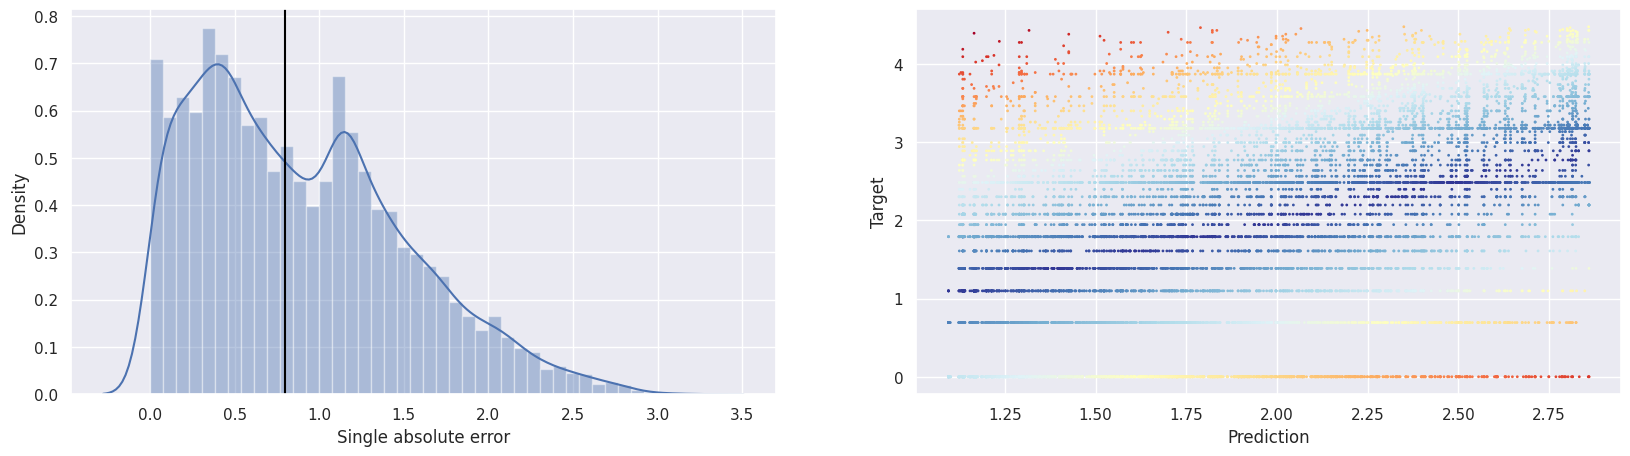

In [ ]:
model.show_val_results();


# New Section

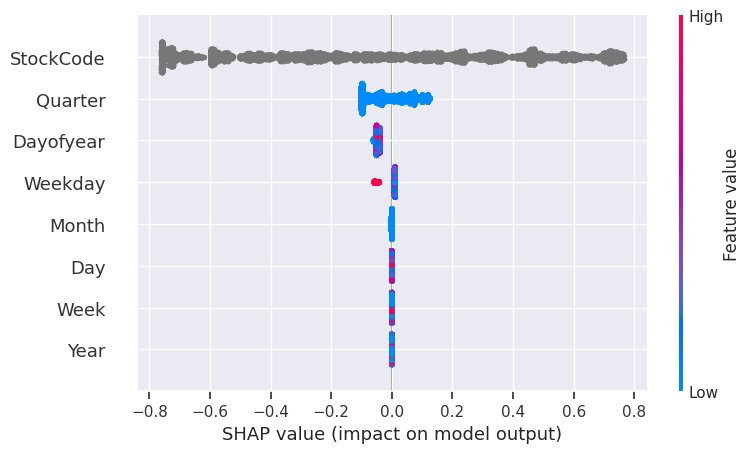

In [ ]:
!pip install shap
import shap
model.show_importances(kind=None)


In [ ]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))


9.720782584931829

In [ ]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))


4.712791042904093

In [ ]:
products = pd.DataFrame(index=data.loc[data.Week < week].StockCode.unique(), columns = ["MedianPrice"])

products["MedianPrice"] = data.loc[data.Week < week].groupby("StockCode").UnitPrice.median()
products["MedianQuantities"] = data.loc[data.Week < week].groupby("StockCode").Quantity.median()
products["Customers"] = data.loc[data.Week < week].groupby("StockCode").CustomerID.nunique()
products["DescriptionLength"] = data.loc[data.Week < week].groupby("StockCode").DescriptionLength.median()
#products["StockCode"] = products.index.values
org_cols = np.copy(products.columns.values)
products.head()

,MedianPrice,MedianQuantities,Customers,DescriptionLength
71053,3.75,4.0,137,19.0
22752,8.50,2.0,163,28.0
21730,4.95,3.0,64,33.0
22633,2.10,4.0,263,22.0
22632,2.10,4.0,227,25.0


In [ ]:
for col in org_cols:
    if col != "StockCode":
        products[col] = boxcox(products[col])[0]


Text(0, 0.5, 'Boxcox-Median-Quantities')

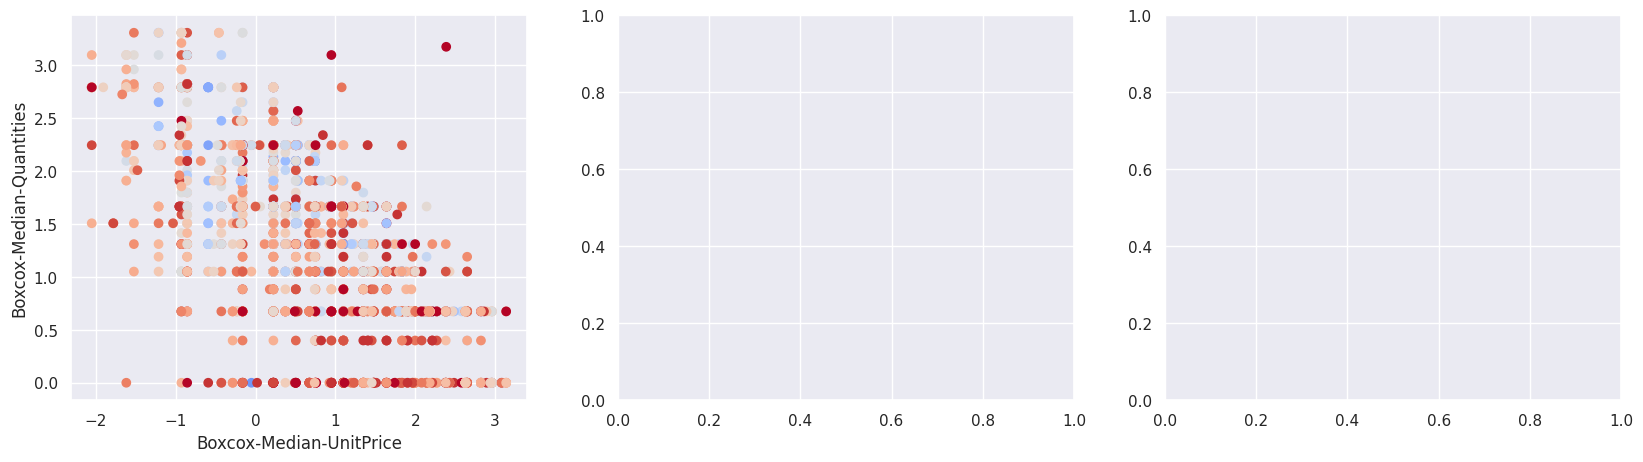

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(products.MedianPrice.values, products.MedianQuantities.values,
           c=products.Customers.values, cmap="coolwarm_r")
ax[0].set_xlabel("Boxcox-Median-UnitPrice")
ax[0].set_ylabel("Boxcox-Median-Quantities")

In [ ]:
X = products.values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
km = KMeans(n_clusters=30)
products["cluster"] = km.fit_predict(X)

daily_data["ProductType"] = daily_data.StockCode.map(products.cluster)
daily_data.ProductType = daily_data.ProductType.astype("object")
daily_data.head()

,Date,Year,Quarter,Month,Week,Weekday,Dayofyear,Day,StockCode,Quantity,Revenue,ProductType
0,2010-12-01,2010,4,12,48,2,335,1,10002,4.094345,51.00,26.0
1,2010-12-01,2010,4,12,48,2,335,1,10125,0.693147,1.70,26.0
2,2010-12-01,2010,4,12,48,2,335,1,10133,1.609438,4.25,10.0
3,2010-12-01,2010,4,12,48,2,335,1,16014,2.302585,4.20,10.0
4,2010-12-01,2010,4,12,48,2,335,1,16016,2.302585,8.50,26.0


In [ ]:
daily_data["KnownStockCodeUnitPriceMedian"] = daily_data.StockCode.map(
    data.groupby("StockCode").UnitPrice.median())

known_price_iqr = data.groupby("StockCode").UnitPrice.quantile(0.75)
known_price_iqr -= data.groupby("StockCode").UnitPrice.quantile(0.25)
daily_data["KnownStockCodeUnitPriceIQR"] = daily_data.StockCode.map(known_price_iqr)

In [ ]:
to_group = ["StockCode", "Year", "Month", "Week", "Weekday"]

daily_data = daily_data.set_index(to_group)
daily_data["KnownStockCodePrice_WW_median"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.median())
daily_data["KnownStockCodePrice_WW_mean"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2)))
daily_data["KnownStockCodePrice_WW_std"] = daily_data.index.map(
    data.groupby(to_group).UnitPrice.std().apply(lambda l: np.round(l, 2)))

daily_data = daily_data.reset_index()

In [ ]:
daily_data.head()


,StockCode,Year,Month,Week,Weekday,Date,Quarter,Dayofyear,Day,Quantity,Revenue,ProductType,KnownStockCodeUnitPriceMedian,KnownStockCodeUnitPriceIQR,KnownStockCodePrice_WW_median,KnownStockCodePrice_WW_mean,KnownStockCodePrice_WW_std
0,10002,2010,12,48,2,2010-12-01,4,335,1,4.094345,51.00,26.0,0.85,0.0000,0.85,0.85,0.0
1,10125,2010,12,48,2,2010-12-01,4,335,1,0.693147,1.70,26.0,0.85,0.0000,0.85,0.85,NaN
2,10133,2010,12,48,2,2010-12-01,4,335,1,1.609438,4.25,10.0,0.42,0.3225,0.85,0.85,NaN
3,16014,2010,12,48,2,2010-12-01,4,335,1,2.302585,4.20,10.0,0.42,0.0000,0.42,0.42,NaN
4,16016,2010,12,48,2,2010-12-01,4,335,1,2.302585,8.50,26.0,0.85,0.0000,0.85,0.85,NaN


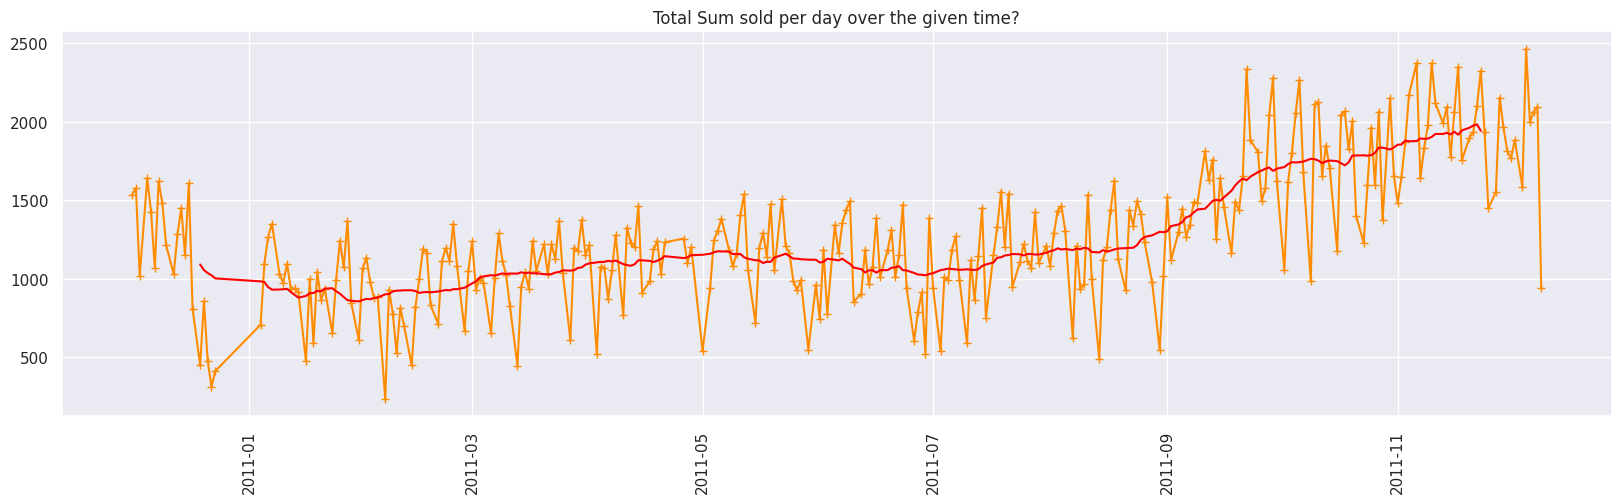

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,5))
plt.plot(daily_data.groupby("Date").Quantity.sum(), marker='+', c="darkorange")
plt.plot(daily_data.groupby("Date").Quantity.sum().rolling(window=30, center=True).mean(),
        c="red")
plt.xticks(rotation=90);
plt.title("Total Sum sold per day over the given time?");

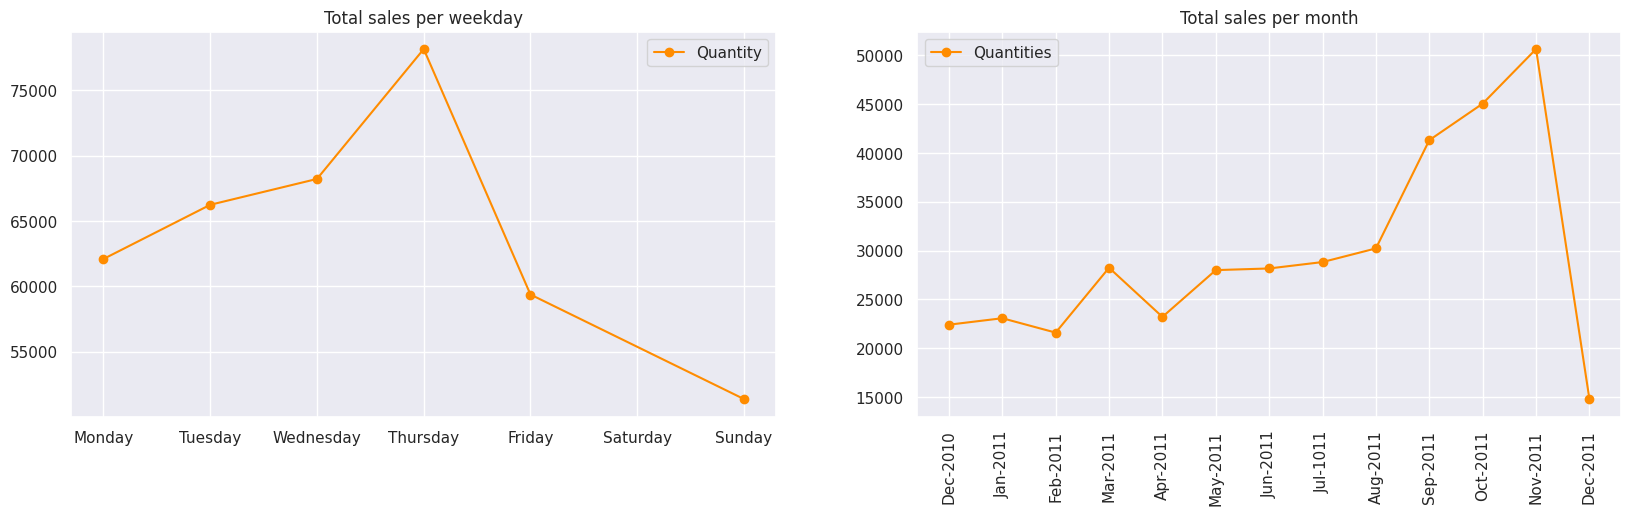

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
yearmonth = ["Dec-2010", "Jan-2011", "Feb-2011", "Mar-2011", "Apr-2011", "May-2011",
             "Jun-2011", "Jul-1011", "Aug-2011", "Sep-2011", "Oct-2011", "Nov-2011",
             "Dec-2011"]

daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[0], marker='o', label="Quantity", c="darkorange");
ax[0].legend();
ax[0].set_xticks(np.arange(0,7))
ax[0].set_xticklabels(weekdays);
ax[0].set_xlabel("")
ax[0].set_title("Total sales per weekday");

ax[1].plot(daily_data.groupby(["Year", "Month"]).Quantity.sum().values,
    marker='o', label="Quantities", c="darkorange");
ax[1].set_xticklabels(yearmonth, rotation=90)
ax[1].set_xticks(np.arange(0, len(yearmonth)))
ax[1].legend();
ax[1].set_title("Total sales per month");

In [ ]:
daily_data["PreChristmas"] = (daily_data.Dayofyear <= 358) & (daily_data.Dayofyear >= 243)


In [ ]:
for col in ["Weekday", "Month", "Quarter"]:
    daily_data = daily_data.set_index(col)
    daily_data[col+"Quantity_mean"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.mean()
    daily_data[col+"Quantity_median"] = daily_data.loc[daily_data.Week < week].groupby(col).Quantity.median()
    daily_data[col+"Quantity_mean_median_diff"] = daily_data[col+"Quantity_mean"] - daily_data[col+"Quantity_median"]
    daily_data[col+"Quantity_IQR"] = daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.75) - daily_data.loc[
        daily_data.Week < week].groupby(col).Quantity.quantile(0.25)
    daily_data = daily_data.reset_index()
daily_data.head()

,Quarter,Month,Weekday,StockCode,Year,Week,Date,Dayofyear,Day,Quantity,...,WeekdayQuantity_mean_median_diff,WeekdayQuantity_IQR,MonthQuantity_mean,MonthQuantity_median,MonthQuantity_mean_median_diff,MonthQuantity_IQR,QuarterQuantity_mean,QuarterQuantity_median,QuarterQuantity_mean_median_diff,QuarterQuantity_IQR
0,4,12,2,10002,2010,48,2010-12-01,335,1,4.094345,...,-0.24129,1.89712,1.970038,2.079442,-0.109404,1.845827,2.024358,2.079442,-0.055084,1.89712
1,4,12,2,10125,2010,48,2010-12-01,335,1,0.693147,...,-0.24129,1.89712,1.970038,2.079442,-0.109404,1.845827,2.024358,2.079442,-0.055084,1.89712
2,4,12,2,10133,2010,48,2010-12-01,335,1,1.609438,...,-0.24129,1.89712,1.970038,2.079442,-0.109404,1.845827,2.024358,2.079442,-0.055084,1.89712
3,4,12,2,16014,2010,48,2010-12-01,335,1,2.302585,...,-0.24129,1.89712,1.970038,2.079442,-0.109404,1.845827,2.024358,2.079442,-0.055084,1.89712
4,4,12,2,16016,2010,48,2010-12-01,335,1,2.302585,...,-0.24129,1.89712,1.970038,2.079442,-0.109404,1.845827,2.024358,2.079442,-0.055084,1.89712


In [ ]:
to_group = ["StockCode", "PreChristmas"]
daily_data = daily_data.set_index(to_group)
daily_data["PreChristmasMeanQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.mean().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasMedianQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.median().apply(lambda l: np.round(l, 1))
daily_data["PreChristmasStdQuantity"] = daily_data.loc[
    daily_data.Week < week].groupby(to_group).Quantity.std().apply(lambda l: np.round(l, 1))
daily_data = daily_data.reset_index()

In [ ]:
for delta in range(1,4):
    to_group = ["Week","Weekday","ProductType"]
    daily_data = daily_data.set_index(to_group)

    daily_data["QuantityProducttypeWeekWeekdayLag_" + str(delta) + "_median"] = daily_data.groupby(
        to_group).Quantity.median().apply(lambda l: np.round(l,1)).shift(delta)

    daily_data = daily_data.reset_index()
    daily_data.loc[daily_data.Week >= (week+delta),
                   "QuantityProductTypeWeekWeekdayLag_" + str(delta) + "_median"] = np.nan

In [ ]:
data["ProductType"] = data.StockCode.map(products.cluster)


In [ ]:
daily_data["TransactionsPerProductType"] = daily_data.ProductType.map(data.loc[data.Week < week].groupby("ProductType").InvoiceNo.nunique())


In [ ]:
delta = 1
to_group = ["Week", "Weekday", "ProductType"]
daily_data = daily_data.set_index(to_group)
daily_data["DummyWeekWeekdayAttraction"] = data.groupby(to_group).CustomerID.nunique()
daily_data["DummyWeekWeekdayMeanUnitPrice"] = data.groupby(to_group).UnitPrice.mean().apply(lambda l: np.round(l, 2))

daily_data["WeekWeekdayAttraction_Lag1"] = daily_data["DummyWeekWeekdayAttraction"].shift(1)
daily_data["WeekWeekdayMeanUnitPrice_Lag1"] = daily_data["DummyWeekWeekdayMeanUnitPrice"].shift(1)

daily_data = daily_data.reset_index()
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayAttraction_Lag1"] = np.nan
daily_data.loc[daily_data.Week >= (week + delta), "WeekWeekdayMeanUnitPrice_Lag1"] = np.nan
daily_data = daily_data.drop(["DummyWeekWeekdayAttraction", "DummyWeekWeekdayMeanUnitPrice"], axis=1)

In [ ]:
daily_data["TransactionsPerStockCode"] = daily_data.StockCode.map(
    data.loc[data.Week < week].groupby("StockCode").InvoiceNo.nunique())

In [ ]:
daily_data.head()


,Week,Weekday,ProductType,StockCode,PreChristmas,Quarter,Month,Year,Date,Dayofyear,...,QuantityProducttypeWeekWeekdayLag_1_median,QuantityProductTypeWeekWeekdayLag_1_median,QuantityProducttypeWeekWeekdayLag_2_median,QuantityProductTypeWeekWeekdayLag_2_median,QuantityProducttypeWeekWeekdayLag_3_median,QuantityProductTypeWeekWeekdayLag_3_median,TransactionsPerProductType,WeekWeekdayAttraction_Lag1,WeekWeekdayMeanUnitPrice_Lag1,TransactionsPerStockCode
0,48,2,26.0,10002,True,4,12,2010,2010-12-01,335,...,2.3,NaN,2.3,NaN,2.5,NaN,3427.0,NaN,NaN,33.0
1,48,2,26.0,10125,True,4,12,2010,2010-12-01,335,...,2.3,NaN,2.3,NaN,2.5,NaN,3427.0,41.0,1.08,50.0
2,48,2,10.0,10133,True,4,12,2010,2010-12-01,335,...,2.5,NaN,0.7,NaN,0.7,NaN,3056.0,41.0,1.08,107.0
3,48,2,10.0,16014,True,4,12,2010,2010-12-01,335,...,2.5,NaN,0.7,NaN,0.7,NaN,3056.0,32.0,0.47,38.0
4,48,2,26.0,16016,True,4,12,2010,2010-12-01,335,...,2.3,NaN,2.3,NaN,2.5,NaN,3427.0,32.0,0.47,53.0


In [ ]:
daily_data["CustomersPerWeekday"] = daily_data.Month.map(
    data.loc[data.Week < week].groupby("Weekday").CustomerID.nunique())

In [ ]:
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity
params = CatHyperparameter()

model = Catmodel("new_features_1", params)
model.set_data(X,y, week)
model.learn(plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

new_features_1, early-stopped model tree count 698


In [ ]:
model.score()


0.4720343847576266

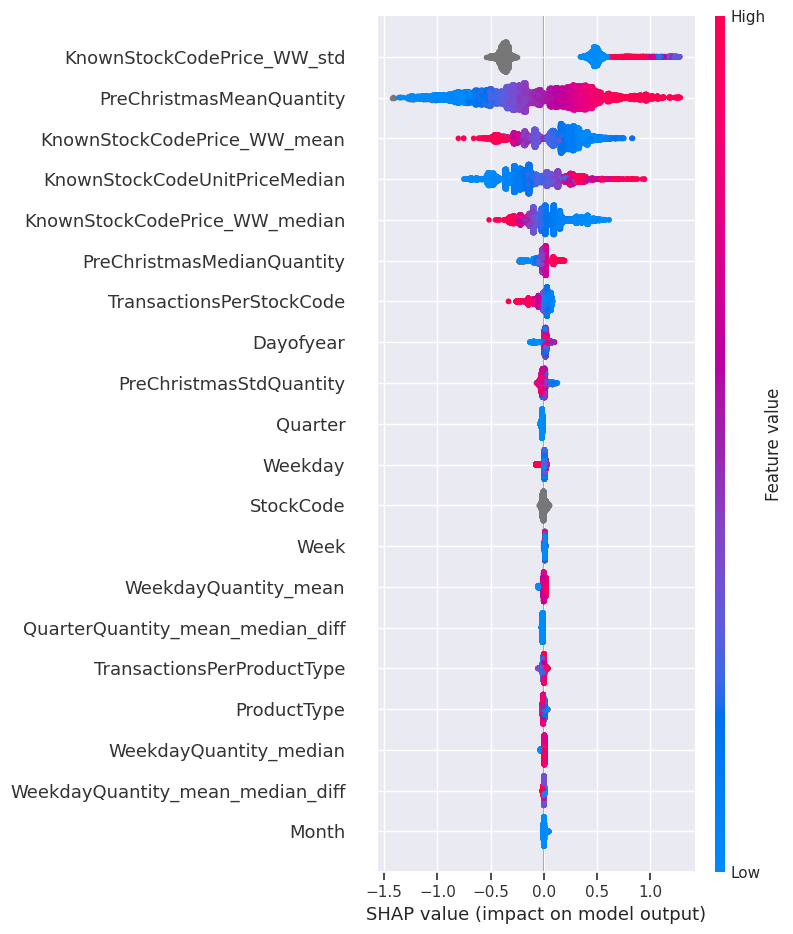

In [ ]:
model.show_importances(kind=None)


Median absolute error: 0.5879711120566571


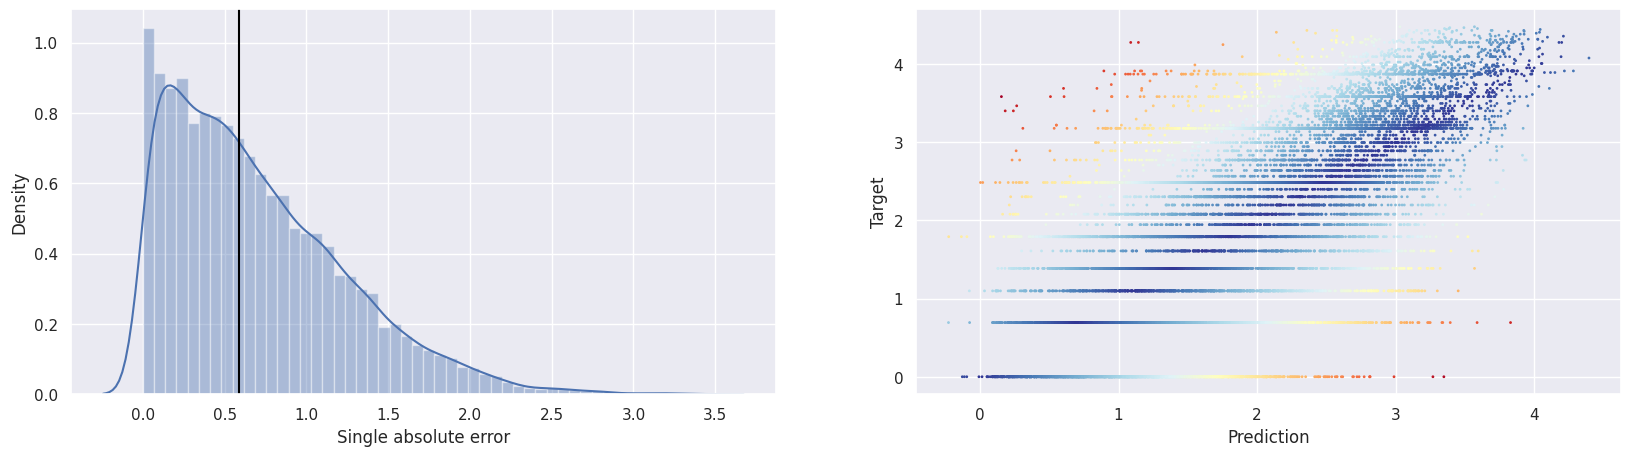

In [ ]:
model.show_val_results();


In [ ]:
np.mean(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))


7.618534883172102

In [ ]:
np.median(np.abs(np.exp(model.results.prediction) - np.exp(model.results.Quantity)))


3.9687423461619367

XGBOOST

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

# Assuming daily_data, week, CatHyperparameter, and Catmodel are defined from your previous code
# Data Preparation
daily_data['StockCode'] = daily_data['StockCode'].astype('int')
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity

# XGBoost Model with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

xgb_model = XGBRegressor()
grid_search = GridSearchCV(xgb_model, param_grid, scoring='neg_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Displaying the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Training XGBoost with best hyperparameters and 10-fold cross-validation status report
best_params = grid_search.best_params_
xgb_model = XGBRegressor(**best_params)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Fold {i+1}/{kf.get_n_splits()} - Mean Squared Error: {mse}")

# You can further analyze the results or save the model if needed


Fitting 10 folds for each of 27 candidates, totalling 270 fits
Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 200}
Fold 1/10 - Mean Squared Error: 0.526470471838814
Fold 2/10 - Mean Squared Error: 0.5265153975750153
Fold 3/10 - Mean Squared Error: 0.5316812551875606
Fold 4/10 - Mean Squared Error: 0.5208211005208991
Fold 5/10 - Mean Squared Error: 0.5380144957542307
Fold 6/10 - Mean Squared Error: 0.5264134197327062
Fold 7/10 - Mean Squared Error: 0.5297417335702345
Fold 8/10 - Mean Squared Error: 0.5329624253442741
Fold 9/10 - Mean Squared Error: 0.5315138860719241
Fold 10/10 - Mean Squared Error: 0.5314241790628069


In [ ]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

# Assuming daily_data, week, CatHyperparameter, and Catmodel are defined from your previous code
daily_data['StockCode'] = daily_data['StockCode'].astype('int')
# Data Preparation
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity

# LightGBM Model with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

lgb_model = LGBMRegressor()
grid_search = GridSearchCV(lgb_model, param_grid, scoring='neg_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Displaying the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Training LightGBM with best hyperparameters and 10-fold cross-validation status report
best_params = grid_search.best_params_
lgb_model = LGBMRegressor(**best_params)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    lgb_model.fit(X_train, y_train)
    y_pred = lgb_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Fold {i+1}/{kf.get_n_splits()} - Mean Squared Error: {mse}")

# You can further analyze the results or save the model if needed


Fitting 10 folds for each of 27 candidates, totalling 270 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 190653, number of used features: 37
[LightGBM] [Info] Start training from score 2.021669
Best Hyperparameters: {'learning_rate': 0.2, 'max_depth': 9, 'n_estimators': 200}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Assuming daily_data, week, CatHyperparameter, and Catmodel are defined from your previous code

# Data Preparation
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity

# Imputing missing values
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)

# AdaBoost Model with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

ada_model = AdaBoostRegressor()

grid_search = GridSearchCV(ada_model, param_grid, scoring='neg_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)
grid_search.fit(X, y)

# Displaying the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Training AdaBoost with best hyperparameters and 10-fold cross-validation status report
best_params = grid_search.best_params_
ada_model = AdaBoostRegressor(**best_params)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    ada_model.fit(X_train, y_train)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Assuming daily_data, week, CatHyperparameter, and Catmodel are defined from your previous code

# Data Preparation
X = daily_data.drop(["Quantity", "Revenue", "Date", "Year"], axis=1)
y = daily_data.Quantity

# Impute missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# AdaBoost Model with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

ada_model = AdaBoostRegressor()

grid_search = GridSearchCV(ada_model, param_grid, scoring='neg_mean_squared_error', cv=kf, verbose=1, n_jobs=-1)
grid_search.fit(X_imputed, y)

# Displaying the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Training AdaBoost with best hyperparameters and printing RMSE for every fold
best_params = grid_search.best_params_
ada_model = AdaBoostRegressor(**best_params)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_index, test_index) in enumerate(kf.split(X_imputed)):
    X_train, X_test = X_imputed[train_index], X_imputed[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    ada_model.fit(X_train, y_train)
    y_pred = ada_model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Fold {i+1}/{kf.get_n_splits()} - RMSE: {rmse}")


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Best Hyperparameters: {'learning_rate': 0.2, 'n_estimators': 50}
Fold 1/10 - RMSE: 0.8573272866281333
Fold 2/10 - RMSE: 0.8581838706906213
Fold 3/10 - RMSE: 0.8523263825525583
Fold 4/10 - RMSE: 0.8503147926366319
Fold 5/10 - RMSE: 0.857657231579112
Fold 6/10 - RMSE: 0.8554730303690249
Fold 7/10 - RMSE: 0.8544591170067383
Fold 8/10 - RMSE: 0.8583613488669709
Fold 9/10 - RMSE: 0.8533734703225305
Fold 10/10 - RMSE: 0.8579951371209517


RMSE for 4th fold: 0.8573650171979328


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (13).

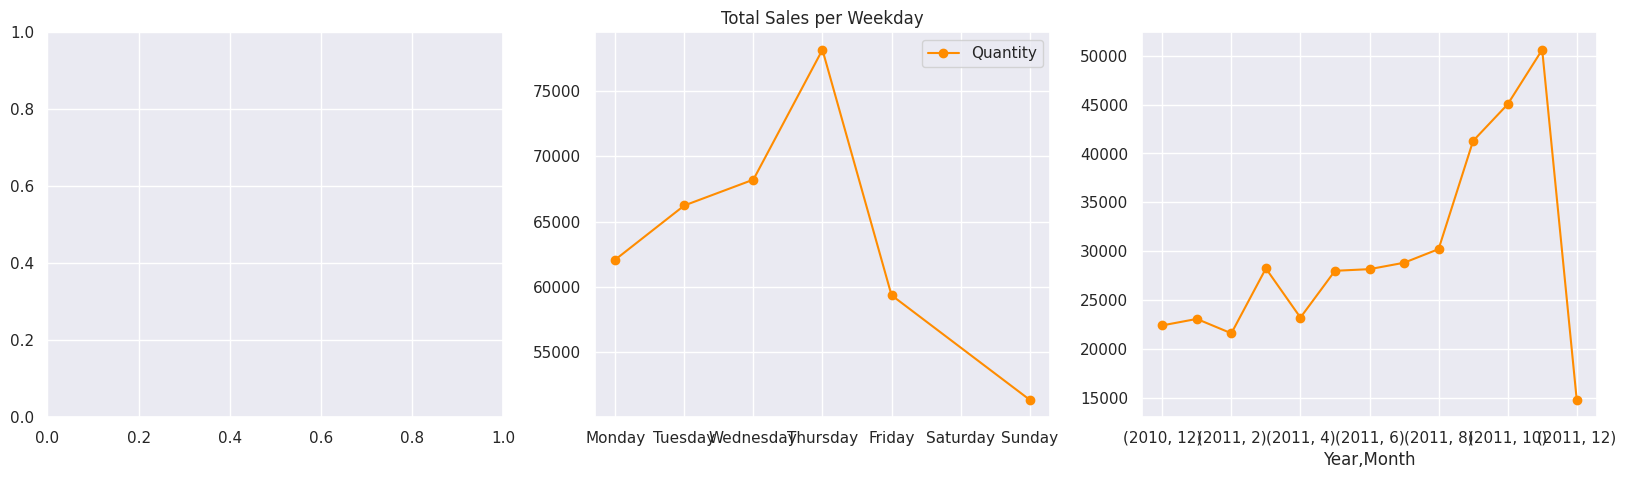

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Assuming you have a time series of features X and target variable y
# X_train, X_test, y_train, y_test should be defined based on the 4th fold

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Hyperparameters for AdaBoost
hyperparameters = {'learning_rate': 0.1, 'n_estimators': 200}

# Create an AdaBoostRegressor
ada_model = AdaBoostRegressor(**hyperparameters)

# Fit the model
ada_model.fit(X_train, y_train)

# Predict on the test set
y_pred = ada_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE for 4th fold: {rmse}")

# Plot the time series graph
fig, ax = plt.subplots(1, 3, figsize=(20, 5))



# Plot total sales per weekday
daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[1], marker='o', label="Quantity", c="darkorange")
ax[1].legend()
ax[1].set_xticks(np.arange(0, 7))
ax[1].set_xticklabels(weekdays)
ax[1].set_xlabel("")
ax[1].set_title("Total Sales per Weekday")

# Plot total sales per year
daily_data.groupby(["Year", "Month"]).Quantity.sum().plot(
    ax=ax[2], marker='o', label="Quantity", c="darkorange")
ax[2].set_xticklabels(yearmonth, rotation=90)
ax[2].set_xticks(np.arange(0, len(yearmonth)))
ax[2].legend()
ax[2].set_title("Total Sales per Year")

plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2313
[LightGBM] [Info] Number of data points in the train set: 171588, number of used features: 37
[LightGBM] [Info] Start training from score 2.023185
RMSE for 4th fold: 0.7404041113035768


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (13).

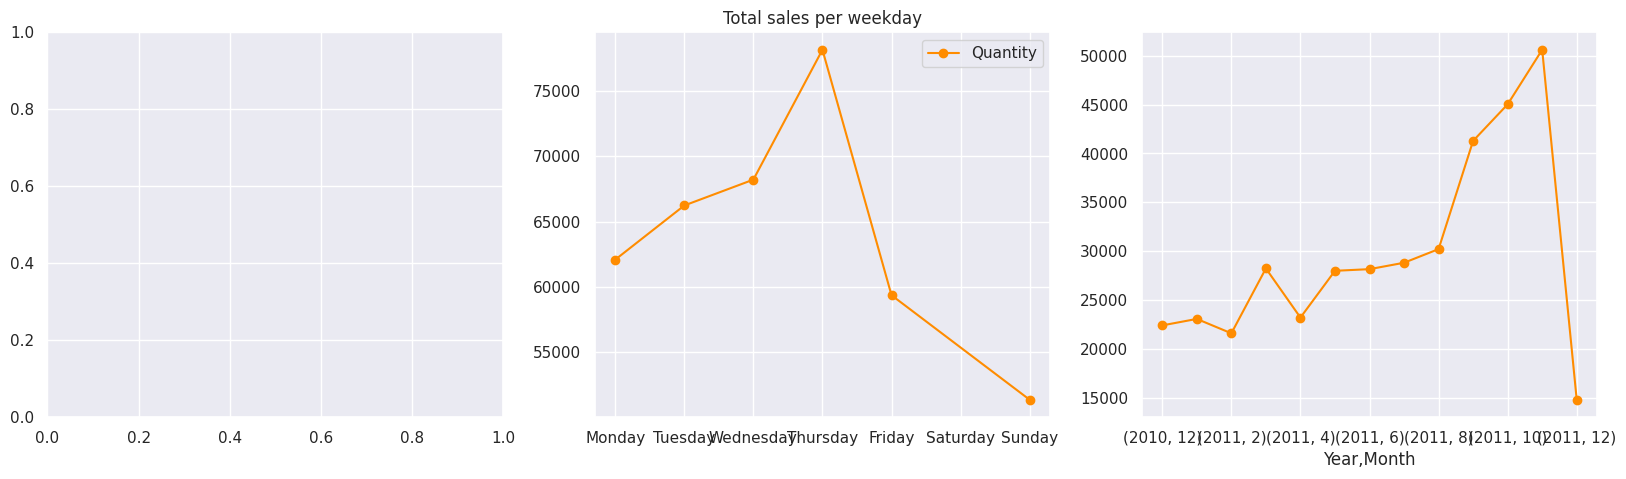

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Assuming you have a time series of features X and target variable y
# X_train, X_test, y_train, y_test should be defined based on the 4th fold

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Hyperparameters for LightGBM with explicit num_leaves
hyperparameters = {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}

# Create a LightGBM Regressor
lgb_model = lgb.LGBMRegressor(**hyperparameters)

# Fit the model
lgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = lgb_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE for 4th fold: {rmse}")

# Plot the time series graphs
fig, ax = plt.subplots(1, 3, figsize=(20, 5))



# Plot total sales per weekday
daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[1], marker='o', label="Quantity", c="darkorange")
ax[1].legend()
ax[1].set_xticks(np.arange(0, 7))
ax[1].set_xticklabels(weekdays)
ax[1].set_xlabel("")
ax[1].set_title("Total sales per weekday")

# Plot total sales per month (yearly plot)
daily_data.groupby(["Year", "Month"]).Quantity.sum().plot(
    ax=ax[2], marker='o', label="Quantities", c="darkorange")
ax[2].set_xticklabels(yearmonth, rotation=90)
ax[2].set_xticks(np.arange(0, len(yearmonth)))
ax[2].legend()
ax[2].set_title("Total sales per month")

# Show the plots
plt.show()


RMSE for 4th fold: 0.7671813601542657


ValueError: The number of FixedLocator locations (9), usually from a call to set_ticks, does not match the number of labels (13).

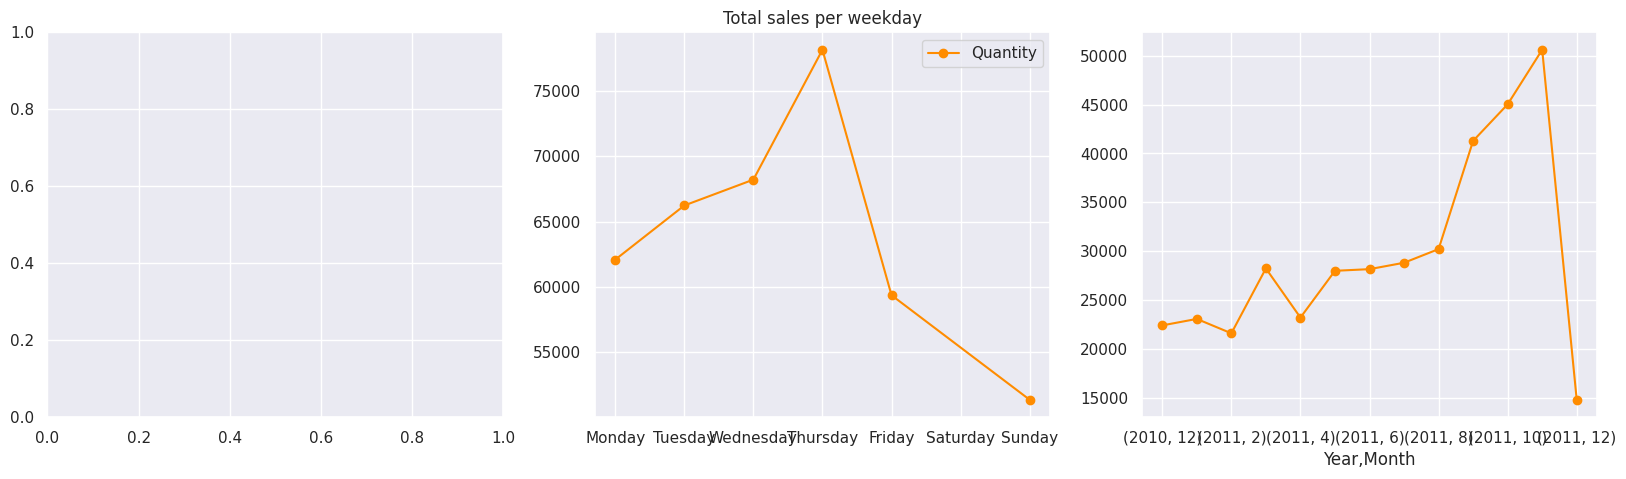

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Assuming you have a time series of features X and target variable y
# X_train, X_test, y_train, y_test should be defined based on the 4th fold

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)

# Hyperparameters for XGBoost
hyperparameters = {'learning_rate': 0.1, 'n_estimators': 200, 'max_depth': 3}

# Create an XGBoost Regressor
xgb_model = xgb.XGBRegressor(**hyperparameters)

# Fit the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE for 4th fold: {rmse}")

# Plot the time series graphs
fig, ax = plt.subplots(1, 3, figsize=(20, 5))



# Plot total sales per weekday
daily_data.groupby("Weekday").Quantity.sum().plot(
    ax=ax[1], marker='o', label="Quantity", c="darkorange")
ax[1].legend()
ax[1].set_xticks(np.arange(0, 7))
ax[1].set_xticklabels(weekdays)
ax[1].set_xlabel("")
ax[1].set_title("Total sales per weekday")

# Plot total sales per month (yearly plot)
daily_data.groupby(["Year", "Month"]).Quantity.sum().plot(
    ax=ax[2], marker='o', label="Quantities", c="darkorange")
ax[2].set_xticklabels(yearmonth, rotation=90)
ax[2].set_xticks(np.arange(0, len(yearmonth)))
ax[2].legend()
ax[2].set_title("Total sales per month")

# Show the plots
plt.show()
